<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/jax_dft/examples/training_neural_xc_functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Setup

Change to GPU runtime: Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [2]:
# Check cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


The jaxlib version must correspond to the version of the existing CUDA installation you want to use, with e.g. `cuda111` for CUDA 11.1.

In [3]:
# For GPU runtime
!pip install --upgrade pip
!pip install --upgrade jaxlib==0.1.72+cuda111 jax==0.2.19 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [4]:
# Install jax-dft
!git clone https://github.com/google-research/google-research.git
!pip install google-research/jax_dft

In [5]:
!rm -rf h2
!wget https://github.com/google-research/google-research/raw/master/jax_dft/data/h2.zip
!unzip h2.zip

--2020-10-28 05:59:55--  https://github.com/google-research/google-research/raw/master/jax_dft/data/h2.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/google-research/master/jax_dft/data/h2.zip [following]
--2020-10-28 05:59:56--  https://raw.githubusercontent.com/google-research/google-research/master/jax_dft/data/h2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420194 (410K) [application/zip]
Saving to: ‘h2.zip’

h2.zip              100%[===================>] 410.35K  --.-KB/s    in 0.02s   

2020-10-28 05:59:56 (16.7 MB/s) - ‘h2.zip’ saved [420194/420194]

Archive:  h2.zi

In [6]:
!wget https://github.com/google-research/google-research/raw/master/jax_dft/data/h2_optimal.pkl

--2020-10-28 05:59:56--  https://github.com/google-research/google-research/raw/master/jax_dft/data/h2_optimal.pkl
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/google-research/master/jax_dft/data/h2_optimal.pkl [following]
--2020-10-28 05:59:56--  https://raw.githubusercontent.com/google-research/google-research/master/jax_dft/data/h2_optimal.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905 (13K) [application/octet-stream]
Saving to: ‘h2_optimal.pkl’

h2_optimal.pkl      100%[===================>]  12.60K  --.-KB/s    in 0s      

2020-10-28 05:59:56 (97.7 MB/s) - ‘h2_opti

In [7]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_deterministic_reductions'

import glob
import pickle
import time
import jax
from jax import random
from jax import tree_util
from jax import config
import jax.numpy as jnp
from jax_dft import datasets
from jax_dft import jit_scf
from jax_dft import losses
from jax_dft import neural_xc
from jax_dft import np_utils
from jax_dft import scf
from jax_dft import utils
from jax_dft import xc
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Set the default dtype as float64
config.update('jax_enable_x64', True)

In [8]:
print(f'JAX devices: {jax.devices()}')

JAX devices: [GpuDevice(id=0)]


# Load data

In [9]:
train_distances = [128, 384]  #@param

dataset = datasets.Dataset(path='h2/', num_grids=513)
grids = dataset.grids
train_set = dataset.get_molecules(train_distances)

In [10]:
#@title Check distances are symmetric
if not np.all(utils.location_center_at_grids_center_point(
    train_set.locations, grids)):
  raise ValueError(
      'Training set contains examples '
      'not centered at the center of the grids.')

In [11]:
#@title Initial density
initial_density = scf.get_initial_density(train_set, method='noninteracting')

# Train neural XC functional with KS regularizer


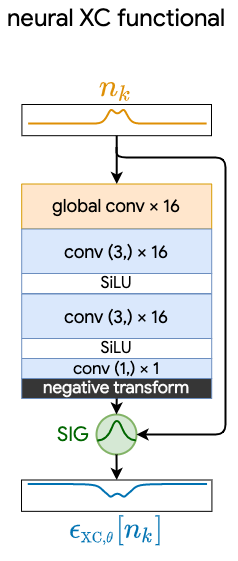

In [12]:
#@title Initialize network
network = neural_xc.build_global_local_conv_net(
    num_global_filters=16,
    num_local_filters=16,
    num_local_conv_layers=2,
    activation='swish',
    grids=grids,
    minval=0.1,
    maxval=2.385345,
    downsample_factor=0)
network = neural_xc.wrap_network_with_self_interaction_layer(
    network, grids=grids, interaction_fn=utils.exponential_coulomb)
init_fn, neural_xc_energy_density_fn = neural_xc.global_functional(
    network, grids=grids)
init_params = init_fn(random.PRNGKey(0))
initial_checkpoint_index = 0
spec, flatten_init_params = np_utils.flatten(init_params)
print(f'number of parameters: {len(flatten_init_params)}')

number of parameters: 1568


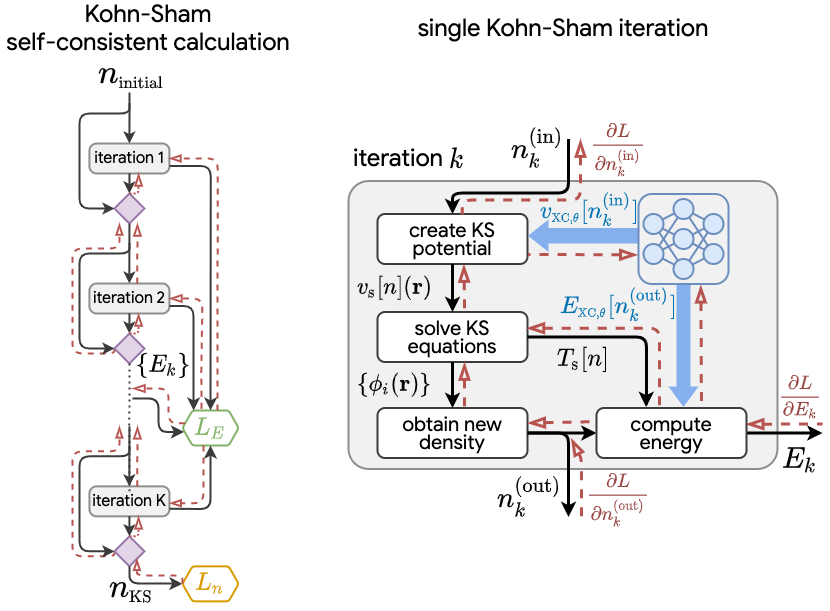

In [13]:
#@markdown The number of Kohn-Sham iterations in training.
num_iterations = 15 #@param{'type': 'integer'}
#@markdown The density linear mixing factor.
alpha = 0.5 #@param{'type': 'number'}
#@markdown Decay factor of density linear mixing factor.
alpha_decay = 0.9 #@param{'type': 'number'}
#@markdown The number of density differences in the previous iterations to mix the
#@markdown density. Linear mixing is num_mixing_iterations = 1.
num_mixing_iterations = 1 #@param{'type': 'integer'}
#@markdown The stopping criteria of Kohn-Sham iteration on density.
density_mse_converge_tolerance = -1. #@param{'type': 'number'}
#@markdown Apply stop gradient on the output state of this step and all steps
#@markdown before. The first KS step is indexed as 0. Default -1, no stop gradient
#@markdown is applied.
stop_gradient_step=-1 #@param{'type': 'integer'}

def _kohn_sham(flatten_params, locations, nuclear_charges, initial_density):
  return jit_scf.kohn_sham(
      locations=locations,
      nuclear_charges=nuclear_charges,
      num_electrons=dataset.num_electrons,
      num_iterations=num_iterations,
      grids=grids,
      xc_energy_density_fn=tree_util.Partial(
          neural_xc_energy_density_fn,
          params=np_utils.unflatten(spec, flatten_params)),
      interaction_fn=utils.exponential_coulomb,
      # The initial density of KS self-consistent calculations.
      initial_density=initial_density,
      alpha=alpha,
      alpha_decay=alpha_decay,
      enforce_reflection_symmetry=True,
      num_mixing_iterations=num_mixing_iterations,
      density_mse_converge_tolerance=density_mse_converge_tolerance,
      stop_gradient_step=stop_gradient_step)
_batch_jit_kohn_sham = jax.vmap(_kohn_sham, in_axes=(None, 0, 0, 0))

grids_integration_factor = utils.get_dx(grids) * len(grids)

def loss_fn(
    flatten_params, locations, nuclear_charges,
    initial_density, target_energy, target_density):
  """Get losses."""
  states = _batch_jit_kohn_sham(
      flatten_params, locations, nuclear_charges, initial_density)
  # Energy loss
  loss_value = losses.trajectory_mse(
      target=target_energy,
      predict=states.total_energy[
          # The starting states have larger errors. Ignore the number of 
          # starting states (here 10) in loss.
          :, 10:],
      # The discount factor in the trajectory loss.
      discount=0.9) / dataset.num_electrons
  # Density loss
  loss_value += losses.mean_square_error(
      target=target_density, predict=states.density[:, -1, :]
      ) * grids_integration_factor / dataset.num_electrons
  return loss_value

value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

#@markdown The frequency of saving checkpoints.
save_every_n = 20 #@param{'type': 'integer'}

loss_record = []

def np_value_and_grad_fn(flatten_params):
  """Gets loss value and gradient of parameters as float and numpy array."""
  start_time = time.time()
  # Automatic differentiation.
  train_set_loss, train_set_gradient = value_and_grad_fn(
      flatten_params,
      locations=train_set.locations,
      nuclear_charges=train_set.nuclear_charges,
      initial_density=initial_density,
      target_energy=train_set.total_energy,
      target_density=train_set.density)
  step_time = time.time() - start_time
  step = initial_checkpoint_index + len(loss_record)
  print(f'step {step}, loss {train_set_loss} in {step_time} sec')

  # Save checkpoints.
  if len(loss_record) % save_every_n == 0:
    checkpoint_path = f'ckpt-{step:05d}'
    print(f'Save checkpoint {checkpoint_path}')
    with open(checkpoint_path, 'wb') as handle:
      pickle.dump(np_utils.unflatten(spec, flatten_params), handle)

  loss_record.append(train_set_loss)
  return train_set_loss, np.array(train_set_gradient)

In [14]:
#@title Use L-BFGS optimizer to update neural network functional
#@markdown This cell trains the model. Each step takes about 1.6s.
max_train_steps = 200 #@param{'type': 'integer'}

_, _, info = scipy.optimize.fmin_l_bfgs_b(
    np_value_and_grad_fn,
    x0=np.array(flatten_init_params),
    # Maximum number of function evaluations.
    maxfun=max_train_steps,
    factr=1,
    m=20,
    pgtol=1e-14)
print(info)

step 0, loss 0.18682592209915364 in 18.91426110267639 sec
Save checkpoint ckpt-00000
step 1, loss 2.206830723734567 in 1.6032278537750244 sec
step 2, loss 0.03004158671185065 in 1.599245309829712 sec
step 3, loss 0.02553093700506681 in 1.601923942565918 sec
step 4, loss 0.02459630093506849 in 1.6012306213378906 sec
step 5, loss 0.017675425897103497 in 1.601691722869873 sec
step 6, loss 0.013219944665877998 in 1.6036527156829834 sec
step 7, loss 0.011388247872334965 in 1.5963976383209229 sec
step 8, loss 0.009059642195789086 in 1.595712661743164 sec
step 9, loss 0.008083928628033784 in 1.5929219722747803 sec
step 10, loss 0.007451996138282887 in 1.592787742614746 sec
step 11, loss 0.00563641708716168 in 1.5941333770751953 sec
step 12, loss 0.004382577906390241 in 1.5926611423492432 sec
step 13, loss 0.00670619981053802 in 1.5969011783599854 sec
step 14, loss 0.004218570636327058 in 1.5960896015167236 sec
step 15, loss 0.0041349648394521455 in 1.5986874103546143 sec
step 16, loss 0.00409

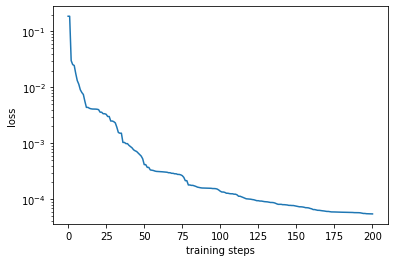

In [15]:
#@title loss curve

plt.plot(np.minimum.accumulate(loss_record))
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('training steps')
plt.show()

# Visualize the model prediction on H$_2$ over training

In [16]:
#@title Helper functions

plot_distances = [40, 56, 72, 88, 104, 120, 136, 152, 184, 200, 216, 232, 248, 264, 280, 312, 328, 344, 360, 376, 392, 408, 424, 456, 472, 488, 504, 520, 536, 568, 584, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

def kohn_sham(
    params, locations, nuclear_charges, initial_density=None, use_lda=False):
  return scf.kohn_sham(
    locations=locations,
    nuclear_charges=nuclear_charges,
    num_electrons=dataset.num_electrons,
    num_iterations=num_iterations,
    grids=grids,
    xc_energy_density_fn=tree_util.Partial(
        xc.get_lda_xc_energy_density_fn() if use_lda else neural_xc_energy_density_fn,
        params=params),
    interaction_fn=utils.exponential_coulomb,
    # The initial density of KS self-consistent calculations.
    initial_density=initial_density,
    alpha=alpha,
    alpha_decay=alpha_decay,
    enforce_reflection_symmetry=True,
    num_mixing_iterations=num_mixing_iterations,
    density_mse_converge_tolerance=density_mse_converge_tolerance)

def get_states(ckpt_path):
  print(f'Load {ckpt_path}')
  with open(ckpt_path, 'rb') as handle:
    params = pickle.load(handle)
  states = []
  for i in range(len(plot_distances)):
    states.append(kohn_sham(
        params,
        locations=plot_set.locations[i],
        nuclear_charges=plot_set.nuclear_charges[i],
        initial_density=plot_initial_density[i]))
  return tree_util.tree_multimap(lambda *x: jnp.stack(x), *states)

In [17]:
#@title Distribution of the model trained with Kohn-Sham regularizer
#@markdown Runtime ~20 minutes for 11 checkpoints.
#@markdown To speed up the calculation, you can reduce the number of
#@markdown separations to compute in
#@markdown `Helper functions -> plot_distances`

ckpt_list = sorted(glob.glob('ckpt-?????'))
num_ckpts = len(ckpt_list)
ckpt_states = []
for ckpt_path in ckpt_list:
  ckpt_states.append(get_states(ckpt_path))

Load ckpt-00000
Load ckpt-00020
Load ckpt-00040
Load ckpt-00060
Load ckpt-00080
Load ckpt-00100
Load ckpt-00120
Load ckpt-00140
Load ckpt-00160
Load ckpt-00180
Load ckpt-00200


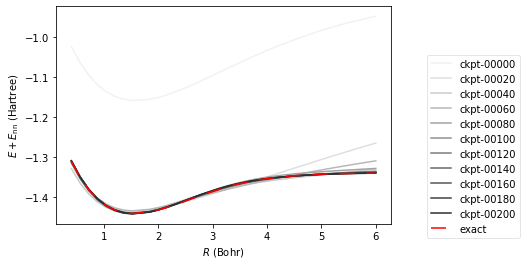

In [29]:
for i, (states, ckpt_path) in enumerate(zip(ckpt_states, ckpt_list)):
  plt.plot(
      np.array(plot_distances) / 100,
      nuclear_energy + states.total_energy[:, -1],
      color=str(0.1 + 0.85 * (num_ckpts - i) / num_ckpts),
      label=ckpt_path)
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(bbox_to_anchor=(1.4, 0.8), framealpha=0.5)
plt.show()

# Visualize the optimal checkpoint in paper

Here we use the neural XC functional trained with Kohn-Sham regularizer in

```
Kohn-Sham equations as regularizer: building prior knowledge into machine-learned physics
Li Li, Stephan Hoyer, Ryan Pederson, Ruoxi Sun, Ekin D. Cubuk, Patrick Riley, and Kieron Burke 
https://arxiv.org/abs/2009.08551
```

## H2 dissociation curve

In [25]:
states = get_states('h2_optimal.pkl')

Load h2_optimal.pkl


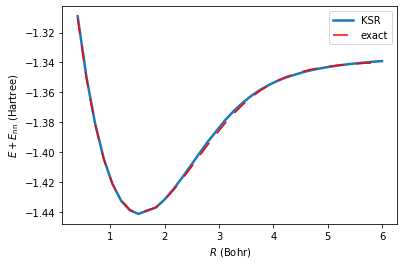

In [33]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='KSR')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

## Solve one H2 separation

In [34]:
distance_x100 = 400 #@param{'type': 'integer'}
#@markdown Plot range on x axis
x_min = -10 #@param{'type': 'number'}
x_max = 10 #@param{'type': 'number'}

with open('h2_optimal.pkl', 'rb') as handle:
  params = pickle.load(handle)

test = dataset.get_molecules([distance_x100])

### Neural XC

In [35]:
solution = kohn_sham(
    params,
    locations=test.locations[0],
    nuclear_charges=test.nuclear_charges[0])

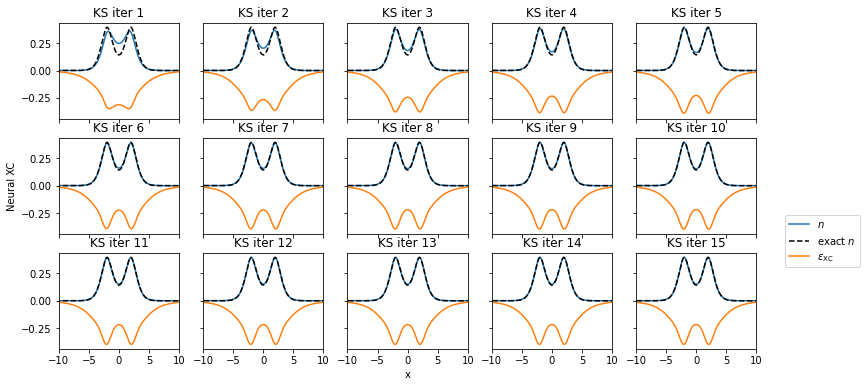

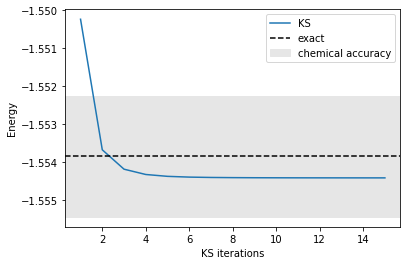

In [40]:
# Density and XC energy density
_, axs = plt.subplots(
    nrows=3,
    ncols=num_iterations // 3,
    figsize=(2.5 * (num_iterations // 3), 6), sharex=True, sharey=True)
axs[2][2].set_xlabel('x')
for i, ax in enumerate(axs.ravel()):
  ax.set_title(f'KS iter {i + 1}')
  ax.plot(grids, solution.density[i], label=r'$n$')
  ax.plot(grids, test.density[0], 'k--', label=r'exact $n$')
  ax.plot(grids, solution.xc_energy_density[i], label=r'$\epsilon_\mathrm{XC}$')
  ax.set_xlim(x_min, x_max)
axs[2][-1].legend(bbox_to_anchor=(1.2, 0.8))
axs[1][0].set_ylabel('Neural XC')
plt.show()

plt.plot(
    1 + np.arange(num_iterations), solution.total_energy,
    label='KS')
truth = test.total_energy[0]
plt.axhline(y=truth, ls='--', color='k', label='exact')
plt.axhspan(
    truth - 0.0016, truth + 0.0016, color='0.9', label='chemical accuracy')
plt.xlabel('KS iterations')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Local density approximation (LDA)

As a comparison, we show the solution on the same molecule using LDA functional:

```
One-dimensional mimicking of electronic structure: The case for exponentials
Thomas E. Baker, E. Miles Stoudenmire, Lucas O. Wagner, Kieron Burke, and Steven R. White
Physical Review B 91.23 (2015): 235141.
```

The LDA functional is implemented in the `jax_dft.xc` module.

In [41]:
lda = kohn_sham(
    None,
    locations=test.locations[0],
    nuclear_charges=test.nuclear_charges[0],
    use_lda=True)

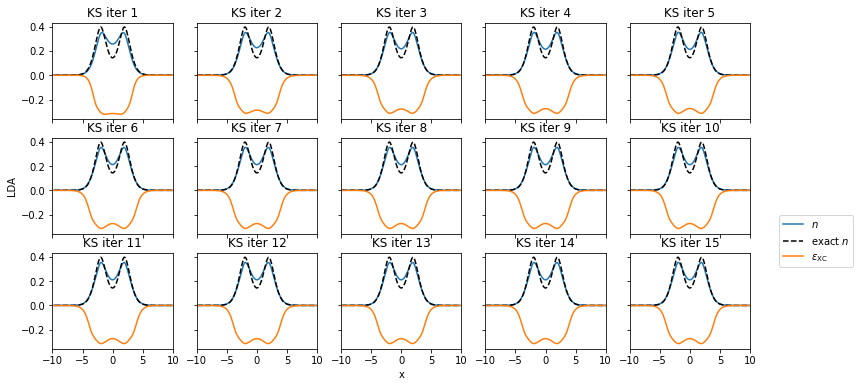

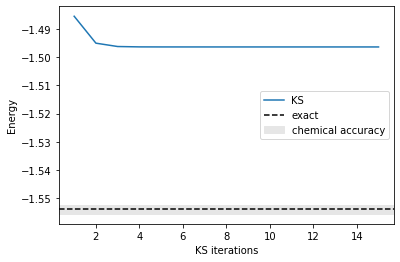

In [42]:
_, axs = plt.subplots(
    nrows=3,
    ncols=num_iterations // 3,
    figsize=(2.5 * (num_iterations // 3), 6), sharex=True, sharey=True)
axs[2][2].set_xlabel('x')
for i, ax in enumerate(axs.ravel()):
  ax.set_title(f'KS iter {i + 1}')
  ax.plot(grids, lda.density[i], label=r'$n$')
  ax.plot(grids, test.density[0], 'k--', label=r'exact $n$')
  ax.plot(grids, lda.xc_energy_density[i], label=r'$\epsilon_\mathrm{XC}$')
  ax.set_xlim(x_min, x_max)
axs[2][-1].legend(bbox_to_anchor=(1.2, 0.8))
axs[1][0].set_ylabel('LDA')
plt.show()

plt.plot(
    1 + np.arange(num_iterations), lda.total_energy,
    label='KS')
truth = test.total_energy[0]
plt.axhline(y=truth, ls='--', color='k', label='exact')
plt.axhspan(
    truth - 0.0016, truth + 0.0016, color='0.9', label='chemical accuracy')
plt.xlabel('KS iterations')
plt.ylabel('Energy')
plt.legend()
plt.show()